In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [24]:
print('''

Rather than raw units, we want to focus on sensitivity and persoanlization? In this example, we walk through a case study
of how to change the ice cream prices to see effect on sales

''')



Rather than raw units, we want to focus on sensitivity and persoanlization? In this example, we walk through a case study
of how to change the ice cream prices to see effect on sales




In [2]:
url='https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/refs/heads/master/causal-inference-for-the-brave-and-true/data/ice_cream_sales_rnd.csv'


In [3]:
prices_rnd = pd.read_csv(url)
print(prices_rnd.shape)
prices_rnd.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


In [4]:
np.random.seed(123)
train, test = train_test_split(prices_rnd)

In [5]:
m1 = smf.ols("sales ~ price + temp+C(weekday)+cost", data=train).fit()
m1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,186.7113,1.770,105.499,0.000,183.241,190.181
C(weekday)[T.2],-25.0512,0.924,-27.114,0.000,-26.863,-23.240
C(weekday)[T.3],-24.5834,0.901,-27.282,0.000,-26.350,-22.817
C(weekday)[T.4],-24.3807,0.897,-27.195,0.000,-26.138,-22.623
C(weekday)[T.5],-24.9036,0.894,-27.850,0.000,-26.657,-23.150
C(weekday)[T.6],-24.0921,0.903,-26.693,0.000,-25.862,-22.323
C(weekday)[T.7],-0.8635,0.888,-0.972,0.331,-2.605,0.878
price,-2.7515,0.106,-25.970,0.000,-2.959,-2.544
temp,1.9848,0.060,33.117,0.000,1.867,2.102
cost,4.4718,0.528,8.462,0.000,3.436,5.508


In [6]:
m2 = smf.ols("sales ~ price*temp + C(weekday) + cost", data=train).fit()
m2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,192.4767,4.371,44.037,0.000,183.907,201.046
C(weekday)[T.2],-25.0805,0.924,-27.143,0.000,-26.892,-23.269
C(weekday)[T.3],-24.5871,0.901,-27.290,0.000,-26.354,-22.821
C(weekday)[T.4],-24.4225,0.897,-27.231,0.000,-26.181,-22.664
C(weekday)[T.5],-24.8953,0.894,-27.844,0.000,-26.648,-23.142
C(weekday)[T.6],-24.1269,0.903,-26.726,0.000,-25.897,-22.357
C(weekday)[T.7],-0.8581,0.888,-0.966,0.334,-2.599,0.883
price,-3.6299,0.618,-5.873,0.000,-4.842,-2.418
temp,1.7459,0.176,9.912,0.000,1.401,2.091
price:temp,0.0366,0.025,1.443,0.149,-0.013,0.086


In [9]:
print('''
Notice that 
 is positive 0,03 and the baseline sensitivity 
 (the sensitivity at 
) is -3.6. This means that, on average, as we increase price, sales go down, which makes sense. It also means that for each additional degree in temperature, people become less sensitive to price increases on ice cream (although not by much). For example, at 
, for each additional BRL we charge, our sales go down by 2.8 units 
. But at 
, for each additional BRL we charge, they go down only by 2.5 units 
. This is also sort of intuitive. As the days get hotter and hotter, people are willing to pay more for ice cream.

''')


Notice that 
 is positive 0,03 and the baseline sensitivity 
 (the sensitivity at 
) is -3.6. This means that, on average, as we increase price, sales go down, which makes sense. It also means that for each additional degree in temperature, people become less sensitive to price increases on ice cream (although not by much). For example, at 
, for each additional BRL we charge, our sales go down by 2.8 units 
. But at 
, for each additional BRL we charge, they go down only by 2.5 units 
. This is also sort of intuitive. As the days get hotter and hotter, people are willing to pay more for ice cream.




In [11]:
m3 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()
m3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,245.5934,3.426,71.684,0.000,238.876,252.310
C(weekday)[T.2],-90.1681,1.969,-45.804,0.000,-94.028,-86.309
C(weekday)[T.3],-89.9918,1.923,-46.788,0.000,-93.763,-86.221
C(weekday)[T.4],-92.8179,1.968,-47.164,0.000,-96.676,-88.959
C(weekday)[T.5],-89.8630,1.920,-46.799,0.000,-93.628,-86.098
C(weekday)[T.6],-94.3701,1.921,-49.125,0.000,-98.136,-90.604
C(weekday)[T.7],-0.6167,1.913,-0.322,0.747,-4.368,3.134
price,-11.2623,0.489,-23.036,0.000,-12.221,-10.304
price:C(weekday)[T.2],9.8965,0.286,34.623,0.000,9.336,10.457
price:C(weekday)[T.3],9.8761,0.276,35.821,0.000,9.336,10.417


In [12]:
def pred_sensitivity(m, df, t="price"):
    return df.assign(**{
        "pred_sens": m.predict(df.assign(**{t:df[t]+1})) - m.predict(df)
    })

pred_sensitivity(m1, test).head()

,temp,weekday,cost,price,sales,pred_sens
2648,18.6,7,0.5,10,185,-2.751463
2456,26.0,3,0.5,10,200,-2.751463
4557,23.7,3,0.3,8,192,-2.751463
4884,28.9,4,1.5,6,213,-2.751463
92,23.7,1,0.5,8,207,-2.751463


In [13]:
pred_sens3 = pred_sensitivity(m3, test)

np.random.seed(1)
pred_sens3.sample(5)

,temp,weekday,cost,price,sales,pred_sens
4764,31.1,6,1.0,3,212,1.144309
4324,24.8,7,0.5,10,182,-9.994303
4536,25.0,2,1.5,6,205,0.279273
3466,26.0,3,1.5,3,205,0.308320
115,19.3,3,0.3,9,177,-0.349745


In [14]:
print('''
Notice how the predictions are numbers that go from something like -9 to something 1. Those are not predictions of the sales column, which is in the order of the hundreds. Rather, it’s a prediction of how much sales would change if we increased price by one unit. Right off of the bet, we can see some strange numbers. For example, take a look at day 4764. It’s predicting a positive sensitivity. In other words, we are predicting that sales will increase if we increase the price of ice cream. This doesn’t appeal to our economic sense. It’s probably the case that the model is doing some weird extrapolation on that prediction. Fortunately, you don’t have to worry too much about it. Remember that our ultimate goal is to segment the units by how sensitive they are to the treatment. It’s not to come up with the most accurate sensitivity prediction ever. For our main goal, it suffices if the sensitivity predictions orders the units according to how sensitive they are. In other words, even if positive sensitivity predictions like 1.1, or 0.5 don’t make much sense, all we need is that the ordering is correct, that is, we want the units with prediction 1.1 to be less impacted by price increase than units with predictions 0.5.
''')


Notice how the predictions are numbers that go from something like -9 to something 1. Those are not predictions of the sales column, which is in the order of the hundreds. Rather, it’s a prediction of how much sales would change if we increased price by one unit. Right off of the bet, we can see some strange numbers. For example, take a look at day 4764. It’s predicting a positive sensitivity. In other words, we are predicting that sales will increase if we increase the price of ice cream. This doesn’t appeal to our economic sense. It’s probably the case that the model is doing some weird extrapolation on that prediction. Fortunately, you don’t have to worry too much about it. Remember that our ultimate goal is to segment the units by how sensitive they are to the treatment. It’s not to come up with the most accurate sensitivity prediction ever. For our main goal, it suffices if the sensitivity predictions orders the units according to how sensitive they are. In other words, even if p

In [15]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"
ml = GradientBoostingRegressor()
ml.fit(train[X], train[y])

# make sure the model is not overfiting.
ml.score(test[X], test[y])

0.9124088322890127

In [16]:
bands_df = pred_sens3.assign(
    sens_band = pd.qcut(pred_sens3["pred_sens"], 2), # create two groups based on sensitivity predictions 
    pred_sales = ml.predict(pred_sens3[X]),
    pred_band = pd.qcut(ml.predict(pred_sens3[X]), 2), # create two groups based on sales predictions
)

bands_df.head()

,temp,weekday,cost,price,sales,pred_sens,sens_band,pred_sales,pred_band
2648,18.6,7,0.5,10,185,-10.301045,"(-10.597999999999999, -0.00555]",186.878081,"(161.089, 198.735]"
2456,26.0,3,0.5,10,200,0.036165,"(-0.00555, 1.389]",203.188327,"(198.735, 257.746]"
4557,23.7,3,0.3,8,192,-0.132057,"(-10.597999999999999, -0.00555]",188.800637,"(161.089, 198.735]"
4884,28.9,4,1.5,6,213,0.860663,"(-0.00555, 1.389]",210.430813,"(198.735, 257.746]"
92,23.7,1,0.5,8,207,-9.953698,"(-10.597999999999999, -0.00555]",209.044522,"(198.735, 257.746]"


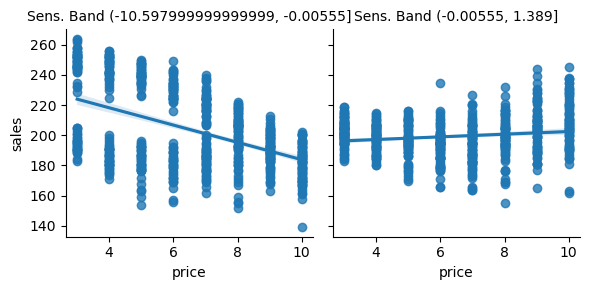

In [22]:
g = sns.FacetGrid(bands_df, col="sens_band")
g.map_dataframe(sns.regplot, x="price", y="sales")
g.set_titles(col_template="Sens. Band {col_name}");

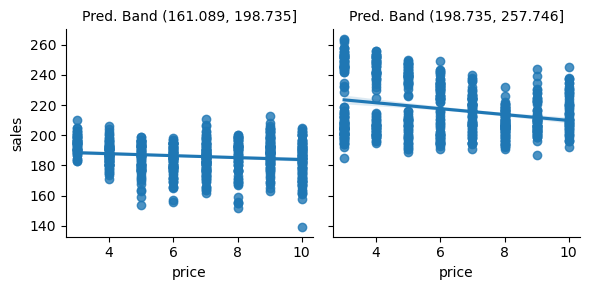

In [23]:
g = sns.FacetGrid(bands_df, col="pred_band")
g.map_dataframe(sns.regplot, x="price", y="sales")
g.set_titles(col_template="Pred. Band {col_name}");